In [9]:
#test
import numpy as np
import csv
import matplotlib.pyplot as plt
from astropy.io.votable import parse_single_table
import time

import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia

# MOSAIC FOV of NGS/PFS Stars for AO

This codes' purpose is to identify the asterisms that can be used as NGS for GLAO correction of MOSAIC at a given pointing. 

To do this there are multiple initial stages:

1) Retrieve the stars that lie within the technical FOV and the science FOV; the former is the overall physical size of the instrument's focal plane, the latter is the subsequent unvignetted region for observations of science objects.

2) Identify which stars are obscured by the LGS footprints

3) Identify which stars are vignetted by the PFS GS arms

By rotating the LGS footprints' angles, and by shifting the FOV slightly, the asterisms at a given pointing for a science object could be dramatically improved. This therefore needs to be optimised.


In [20]:
#=====================================================================================================================
class FOV_stars: #Class for the FOV simulation
    def __init__(self,mag_limit=16):
        self.scienceFOV_diameter=7.4 #Diameter of the science FOV in arcmin
        self.techFOV_diameter=10 #Diameter of the tech FOV in arcmin
        self.mag_limit=mag_limit #Minimum magnitude of stars to consider
        
        #Dummy variables until requirements are provided:
        self.LGS_distance=3.5 #distance of LGS footprints from FOV centre in armin
        self.LGS_radius=1.5 #radius of LGS footprints in arcmin
        self.PFSarm_width=0.5 #distance from PFS star to edge of PFS arm widthways
        self.PFSarm_length=0.5 #distance from PFS star to end of PFS arm
        self.PFSarm_minangle=45 #minimum angle between each PFS arms
        
    def GAIA_query(self,ra,dec):
        job = Gaia.launch_job_async("SELECT * \
        FROM gaiadr3.gaia_source \
        WHERE CONTAINS(POINT(gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE("+str(ra)+","+str(dec)+","+str(10/60)+"))=1 \
        AND phot_g_mean_mag IS NOT NULL \
        AND parallax IS NOT NULL \
        ORDER BY phot_g_mean_mag ASC;", dump_to_file=False)

        GAIA_data = job.get_results()
        
        ra=[]
        dec=[]
        mag=[]
        
        for i in range(0,len(GAIA_data)):
            if GAIA_data['phot_g_mean_mag'][i]<=self.mag_limit:
                mag.append(GAIA_data['phot_g_mean_mag'][i])
                ra.append(GAIA_data['ra'][i])
                dec.append(GAIA_data['dec'][i])

        scales=[] #Need scale values for the marker size of each star to illustrate magnitude on a plot

        for i in mag: #Scale is linear with magnitude from {16}, i.e mag {12} star has marker size {2} times larger than a mag {14} star.
            I=(self.mag_limit-i)
            scales.append(I*15)
        
        stars_data={}

        stars_data['ra']=ra
        stars_data['dec']=dec
        stars_data['mag']=mag
        stars_data['scales']=scales
        stars_data['mag_limit']=self.mag_limit
        stars_data['source']="query"

        self.stars_data=stars_data
            
    def load_field(self): #Loads the stars near GOODS South within 100 arcmin; downloaded using ASQL from GAIA DR3
        table=parse_single_table("CANDLES2")
        CANDLES=table.array

        ra=[] #Right Ascension of stars
        dec=[] #Declination
        mag=[] #Magnitude
        for i in CANDLES[:]: #Converts all mag, ra, and dec into floats (from strings)
            if i[2]!='': #Some observations do not have a magnitude; so these are ignored
                if float(i[69])<=self.mag_limit: #Faint stars of mag {16} and above are ignored
                    mag.append(float(i[69])) 
                    ra.append(float(i[5])) 
                    dec.append(float(i[7]))
                    
        scales=[] #Need scale values for the marker size of each star to illustrate magnitude on a plot

        for i in mag: #Scale is linear with magnitude from {16}, i.e mag {12} star has marker size {2} times larger than a mag {14} star.
            I=(self.mag_limit-i)
            scales.append(I*15)     

        stars_data={}

        stars_data['ra']=ra
        stars_data['dec']=dec
        stars_data['mag']=mag
        stars_data['scales']=scales 
        stars_data['mag_limit']=self.mag_limit
        stars_data['source']="field"

        self.stars_data=stars_data  
#=====================================================================================================================
#Following functions are co-ord conversions for a sphere's azimuthal projection onto a flat surface

#INPUTS:
#ra and dec: input co-ords to be converted in radians
#ra0 and dec0: co-ords of the azimuthal projection's axis in radians
#OUTPUTS:
#x and y: corresponding converted co-ords in the projection plane

    def orthographic(self,ra,dec,ra0,dec0): #Orthographic projection plane around ra0 and dec0
        x=np.cos(dec)*np.sin(ra-ra0)
        y=np.cos(dec0)*np.sin(dec)-np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)
        return x,y
    
#=====================================================================================================================
#Some useful short functions for geometry calculations 
    def distance(self,x,y): #Distance between (0,0) and (x,y):
        d=np.sqrt(x**2+y**2)
        return d  
    
    def line(self,A,B): #Returns gradient (m) and y intercept (c) of a line joining points A and B, form y=m*x+c
        m=(A[1]-B[1])/(A[0]-B[0])
        c=A[1]-m*A[0] 
        return m,c

    def perp_line(self,m,c,C): #Returns gradient and y intercept of a line perpendicular to y=m*x+c going through C
        m_perp=-1/m
        c_perp=C[1]-m_perp*C[0]
        return m_perp,c_perp   
#=====================================================================================================================
#Function converts all stars ra and dec to x and y values on the projection of a sphere to a flat plane

#INPUTS:
#ra0_rad and dec0_rad: pointing of the telescope/centre of FOV in radians
#proj: projection to use; ORTH default, or STER, EQUI, GNOM
#OUTPUTS:
#x and y: co-ords for stars in the chosen projection around ra0 and dec0
   
    def convstars(self,ra0_rad,dec0_rad):
        x=[] #x-coords of stars on projection plane
        y=[] #y-coords of stars on projection plane

        for i in range(0,len(self.stars_data['ra'])): #Loop converts every stars' (ra,dec) to (x,y) in the chosen projection plane
            xval,yval=self.orthographic(np.radians(self.stars_data['ra'][i]),np.radians(self.stars_data['dec'][i]),ra0_rad,dec0_rad) #Angles need to be in radians
            x.append(xval)
            y.append(yval)
        void,self.onearcmin_xy=self.orthographic(ra0_rad,dec0_rad+np.radians(1/60),ra0_rad,dec0_rad) #Length of 1 arcmin in the x,y projection units 
        self.techFOV_xyradius=self.techFOV_diameter/2*self.onearcmin_xy #Using the 1 arcmin length in x,y, converts the technical field diameter to x,y units
        self.scienceFOV_xyradius=self.scienceFOV_diameter/2*self.onearcmin_xy #Using the 1 arcmin length in x,y, converts the science field diameter to x,y units

        return x,y
#=====================================================================================================================
#Function identifies all the stars inside the science and technical annulus FOVs for a given pointing

#INPUTS:
#x_offset and y_offset: the FOV pointing displacement from the azimuthal projection axis in x,y; default 0 and 0
#To be used for optimisation where we identify stars nearby the original FOV without having to recalculate all x,y values for a new projection - saves time
#OUTPUTS:
#sciencestars_index and tech stars_index: indexes of the stars inside the science field and annulus respectively
   
    def findstars(self,x_offset=0,y_offset=0):
        sciencestars_index= [] #Index of stars inside science field
        techstars_index = [] #Index of stars inside technical field and not in science field
        
        for i in range(0,len(self.stars_data['x'])): #Loop retrieves indexes of stars within the radii of the FOVs
            dist = self.distance(self.stars_data['x'][i]-x_offset,self.stars_data['y'][i]-y_offset)
            if  dist < self.techFOV_xyradius:
                if dist < self.scienceFOV_xyradius:
                    sciencestars_index.append(i)
                else:
                    techstars_index.append(i)
        return sciencestars_index,techstars_index
#=====================================================================================================================    
#Function identifies which stars in the FOV are obscured by the footprints of the LGS

#INPUTS:
#LGS_angle: angle of the LGS footprints template, rotating anti-clockwise in radians
#OUTPUTS:
#footprintstars_index: indexes of the stars inside the LGS footprints
#footprintstars_LGS: footprint the respective LGS footprint stars lie in
#LGS_x and LGS_y: the x and y co-ords of the centre of the LGS footprints

    def LGS_footprint(self,LGS_angle):      
        LGS_xyd=self.LGS_distance*self.onearcmin_xy #Distance of LGS footprints from FOV centre in x,y units
        LGS_xyradius=self.LGS_radius*self.onearcmin_xy #Radius of LGS footprint in x,y units
        
        #Following calculates the x and y positions of the 4 LGS footprints using the LGS angle and LGS distance from FOV centre
        LGS_y=[LGS_xyd*np.cos(LGS_angle),LGS_xyd*np.cos(LGS_angle+np.pi/2),LGS_xyd*np.cos(LGS_angle+np.pi),LGS_xyd*np.cos(LGS_angle+3*np.pi/2)]
        LGS_x=[LGS_xyd*np.sin(LGS_angle),LGS_xyd*np.sin(LGS_angle+np.pi/2),LGS_xyd*np.sin(LGS_angle+np.pi),LGS_xyd*np.sin(LGS_angle+3*np.pi/2)]

        footprintstars_index=[] #Indexes of stars inside the LGS footprints
        footprintstars_LGS=[] #LGS footprint number that each obscured star lies in
        
        #Python "freaks out" when removing an element from a list in a loop when that list is used for loop values
        #So following reproduces the list to prevent the freak out
        techstars_index=self.techstars_index.copy()
        sciencestars_index=self.sciencestars_index.copy()
        
        #Following takes x,y of each FOV star and identifies if they are within the equation of a circle for the LGS footprints
        #Stars that are in LGS footprints are removed from the scienceFOV and techFOV lists and are added to the footprints list
        for i in techstars_index:
            for o in range(0,4):
                if (self.stars_data['x'][i]-LGS_x[o])**2+(self.stars_data['y'][i]-LGS_y[o])**2<LGS_xyradius**2:
                    footprintstars_index.append(i)     
                    footprintstars_LGS.append(o+1) 
                    self.techstars_index.remove(i)      
        for i in sciencestars_index:
            for o in range(0,4):
                if (self.stars_data['x'][i]-LGS_x[o])**2+(self.stars_data['y'][i]-LGS_y[o])**2<LGS_xyradius**2:
                    footprintstars_index.append(i)
                    footprintstars_LGS.append(o+1)  
                    self.sciencestars_index.remove(i)
                    
        return footprintstars_index, footprintstars_LGS, LGS_x, LGS_y 
#=====================================================================================================================
#Function picks off the three brightest stars in the outer annulus (with angular constraints of {45} degrees)
#Radial PFS arm co-ords/dimensions are calculated over these stars
#The other FOV stars are then checked if they are vignetted

#INPUTS: #FIX!!!!!!!!
#view: True or False, determines if the specific co-ords of the arms origins should be calculated for plotting graphically
#OUTPUTS:
#PFSstars_index: indexes of stars used as the PFS guide stars - maximum 3
#PFSvignettedstars_index: indexes of stars vignetted by the PFS arms

#NOTE: This will break if the PFS star is at exactly 0, 90, 180, or 270 degrees from +y (north)
#This shouldn't (?) ever happen due to the precision of GAIA -  can be fixed if this does happen

    def PFSarms(self,view):
        PFSarm_xywidth=self.PFSarm_width*self.onearcmin_xy #distance from PFS star to edge of PFS arm widthways in x,y units
        PFSarm_xylength=self.PFSarm_length*self.onearcmin_xy #distance from PFS star to end of PFS arm in x,y units
                            #PFS1,2,3 - order A,B,C,D
        self.PFSarm_corners=[[],[],[]] #List of co-ordinates for the PFS arms' corners (see diagram below)
                           #PFS1,2,3 - inside, have AB, BC, and BD m and c
        self.PFSarm_lines=[[],[],[]]

        #D-----------A
        #            |
        #         x  | ---> FOV Centre
        #            |
        #C-----------B
        
        techstars_mag=[] #Magnitude of stars in the annulus
        for i in self.techstars_index: #Loops retrieves the magnitudes of all the annulus stars
            techstars_mag.append(self.stars_data['mag'][i])
        
        techstars_mag,self.techstars_index = zip(*sorted(zip(techstars_mag,self.techstars_index))) #Sorts the stars in order of magnitudes, brightest first
        
        self.techstars_index=list(self.techstars_index) #Last sort returns a tuple, but we need it as a list
        techstars_index=self.techstars_index.copy() #Python "freak out" fix as detailed in LGS_footprints

        PFSstars_angle=[np.radians(-self.PFSarm_minangle-1)] #This is the angles of PFS stars, anticlockwise from +y (north)
        #The dummy angle inside is needed, allows the check that each PFS star is not within {45} degrees of another
        PFSstars_index=[] #Indexes of stars that are used as PFS guide stars
        PFScount=0 #Number of stars used as PFS guide stars, max 3

        
        for i in techstars_index: #Ordered by magnitude, so brightest stars are checked first
            #The first 4 ifs determine what quadrant the star is in, and then calculates the appropriate angle from +y (north)
            if self.stars_data['x'][i]>0 and self.stars_data['y'][i]>0:
                theta=2*np.pi-np.arctan(self.stars_data['x'][i]/self.stars_data['y'][i])
            elif self.stars_data['x'][i]<0 and self.stars_data['y'][i]>0:
                theta=np.arctan(-self.stars_data['x'][i]/self.stars_data['y'][i])
            elif self.stars_data['x'][i]<0 and self.stars_data['y'][i]<0:
                theta=np.pi-np.arctan(+self.stars_data['x'][i]/self.stars_data['y'][i])
            else: 
                theta=np.pi+np.arctan(-self.stars_data['x'][i]/self.stars_data['y'][i])
            
            #Following if statement determines if the star is not within {45} degrees of a previous PFS star
            if all([abs(theta-previous_angles)>np.radians(self.PFSarm_minangle)
                                        for previous_angles in PFSstars_angle]):
                PFSstars_index.append(i) #Adds the star's index to the PFS stars list
                PFSstars_angle.append(theta) #Adds the star's angle to the PFS stars list
                self.techstars_index.remove(i) #Removes the star's index from the tech stars list.

                #A and B are the corners of the PFS arm towards the FOV centre
                A=(self.stars_data['x'][i]+PFSarm_xylength*np.sin(theta)+PFSarm_xywidth*np.cos(theta),
                   self.stars_data['y'][i]-PFSarm_xylength*np.cos(theta)+PFSarm_xywidth*np.sin(theta))
                B=(self.stars_data['x'][i]+PFSarm_xylength*np.sin(theta)-PFSarm_xywidth*np.cos(theta),
                   self.stars_data['y'][i]-PFSarm_xylength*np.cos(theta)-PFSarm_xywidth*np.sin(theta))

                #Following calculates the gradients and y intercepts of the PFS arms' boundaries, and then are stored in a list
                AB_m,AB_c=self.line(A,B)
                AD_m,AD_c=self.perp_line(AB_m,AB_c,A)
                BC_m,BC_c=self.perp_line(AB_m,AB_c,B)
                self.PFSarm_lines[PFScount].append([AB_m,AB_c])
                self.PFSarm_lines[PFScount].append([AD_m,AD_c])
                self.PFSarm_lines[PFScount].append([BC_m,BC_c])

                #Following calculates C and D positions, the origins of the PFS arms
                if theta<np.pi/2 and theta>-np.pi/2 or theta>3*np.pi/2 or theta<-3*np.pi/2: #Ifs PFS star in top half, origins are at y=+FOV boundary
                    C=((self.techFOV_xyradius-BC_c)/BC_m,self.techFOV_xyradius)
                    D=((self.techFOV_xyradius-AD_c)/AD_m,self.techFOV_xyradius) 
                else: #If PFS star in bottom half, origins are at y=-FOV boundary
                    C=((-self.techFOV_xyradius-BC_c)/BC_m,-self.techFOV_xyradius)
                    D=((-self.techFOV_xyradius-AD_c)/AD_m,-self.techFOV_xyradius)

                #Save all 4 PFS corners for plotting
                self.PFSarm_corners[PFScount].append(A)
                self.PFSarm_corners[PFScount].append(B)
                self.PFSarm_corners[PFScount].append(C)
                self.PFSarm_corners[PFScount].append(D)
                    
                PFScount=PFScount+1 #Counts everytime a PFS star is found
                
            if PFScount==3: #If 3 PFS stars are found, stop finding more
                break
                
        PFSvignettedstars_index=[] #Indexes of stars that are vignetted by PFS arms
        techstars_index=self.techstars_index.copy() #Python "freak out" fix
        sciencestars_index=self.sciencestars_index.copy() #Python "freak out" fix
        #Identifies which stars are vignetted by PFS arms
        for count,i in enumerate(techstars_index+sciencestars_index): #Check each star in the tech and science FOV
            starx=self.stars_data['x'][i]
            stary=self.stars_data['y'][i]
            for o in range(0,PFScount): #Checks each star against each PFS arms
                theta=PFSstars_angle[o+1] #First PFS angle was a dummy value
                AB=self.PFSarm_lines[o][0]
                AD=self.PFSarm_lines[o][1]
                BC=self.PFSarm_lines[o][2]
                #The angle of the PFS star depends on the orientation of the arms sides, and therefore alters the inequality conditions
                if np.pi/2>theta>0:
                    if (stary>AB[0]*starx+AB[1] and stary<AD[0]*starx+AD[1] 
                                                    and stary>BC[0]*starx+BC[1]):
                        PFSvignettedstars_index.append(i)
                        if i in techstars_index:
                            self.techstars_index.remove(i)
                        else: 
                            self.sciencestars_index.remove(i)
                elif np.pi>theta>np.pi/2:
                    if (stary<AB[0]*starx+AB[1] and stary<AD[0]*starx+AD[1]
                                                    and stary>BC[0]*starx+BC[1]):
                        PFSvignettedstars_index.append(i)
                        if i in techstars_index:
                            self.techstars_index.remove(i)
                        else: 
                            self.sciencestars_index.remove(i)
                elif 3*np.pi/2>theta>np.pi:
                    if (stary<AB[0]*starx+AB[1] and stary>AD[0]*starx+AD[1] 
                                                    and stary<BC[0]*starx+BC[1]):
                        PFSvignettedstars_index.append(i)
                        if i in techstars_index:
                            self.techstars_index.remove(i)
                        else: 
                            self.sciencestars_index.remove(i)
                else:
                    if (stary>AB[0]*starx+AB[1] and stary>AD[0]*starx+AD[1]
                                                    and stary<BC[0]*starx+BC[1]):
                        PFSvignettedstars_index.append(i)
                        if i in techstars_index:
                            self.techstars_index.remove(i)
                        else: 
                            self.sciencestars_index.remove(i)
        
        return PFSstars_index,PFSvignettedstars_index,PFSstars_angle
                    
#=====================================================================================================================
#Function identifies the 3 remaining brightest stars after LGS footprints, PFS stars, and PFS vignetting are taken into account
    
#INPUTS: None, uses class variables
#OUTPUTS: 
#NGSasterism_area: area of the asterism in arcmin^2, returns a value of 0 if there are less than 3 PFS stars
#NGSasterism_barycentre: distance of the asterism barycentre to the FOV in arcmin, returns a value of 0 if there are less than 2 PFS stars
 
    def NGSasterism(self):
        NGSstars_mag=[] #Magnitude of the stars that can be used as NGS
        NGSstars_index=self.sciencestars_index #Indexes of stars that can be used as NGS
        
        for i in NGSstars_index: #Retrieves the corresponding magnitudes
            NGSstars_mag.append(self.stars_data['mag'][i])
        
        NGSstars_mag, NGSstars_index = zip(*sorted(zip(NGSstars_mag,NGSstars_index))) #Sorts the lists by magnitude, so brightest stars are first        
        NGSstars_mag=list(NGSstars_mag) #Need the the stars magnitudes in a list, last line returns a tuple
        self.NGSstars_index=list(NGSstars_index) #Need the NGS stars indexes as a class variable list
        
        if len(NGSstars_index)>=3: #If there are 3 or more available NGS stars, calculate area and barycentre
            a=NGSstars_index[0] #Brightest star
            b=NGSstars_index[1]
            c=NGSstars_index[2] 
            
            #Area is found using the Shoelace formula
            NGSasterism_area=((self.stars_data['x'][a]*self.stars_data['y'][b]+self.stars_data['x'][b]*self.stars_data['y'][c]+self.stars_data['x'][c]*self.stars_data['y'][a]
                              -self.stars_data['y'][a]*self.stars_data['x'][b]-self.stars_data['y'][b]*self.stars_data['x'][c]-self.stars_data['y'][c]*self.stars_data['x'][a])/(2*self.onearcmin_xy**2))
            #Barycentre x/y is average of x/y co-ords of the 3 points
            NGSasterism_barycentre=[(self.stars_data['x'][a]+self.stars_data['x'][b]+self.stars_data['x'][c])/3,(self.stars_data['y'][a]+self.stars_data['y'][b]+self.stars_data['y'][c])/3]                                                                                                                                            
            return abs(NGSasterism_area),NGSasterism_barycentre
        
        elif len(NGSstars_index)==2: #If there are 2 available NGS stars, calculate the barycentre
            a=NGSstars_index[0]
            b=NGSstars_index[1]
            NGSasterism_barycentre=[(self.stars_data['x'][a]+self.stars_data['x'][b])/2,(self.stars_data['y'][a]+self.stars_data['y'][b])/2]  
            return 0,NGSasterism_barycentre
        
        elif len(NGSstars_index)==1: #If there is 1 available NGS star, return its' co-ordinates
            a=NGSstars_index[0]
            NGSasterism_barycentre=[self.stars_data['x'][a],self.stars_data['x'][b]]    
            return 0, NGSasterism_barycentre
            
        else: #If there are no available NGS stars, return 0 values
            return 0,0
        
#=====================================================================================================================            
#Following is WIP:
#1) Converts GAIA stars to x,y co-ords in a projection of the sphere onto a flat surface given a pointing
#2) Identifies which stars are inside the MOSAIC FOV
#3) Identifies which stars are inside the footprints of the LGS
#4) Identifies which stars are to be used to the PFS guide stars and which stars are vignetted by PFS arms
#5) Identifies the three (or 2/1/0) brightest remaining stars to use for the NGS asterism and finds their area and barycentre

#INPUTS:
#ra0 and dec0: pointing of the telescope/centre of FOV in ra and dec degrees
#report: does nothing rn
#proj: projection to use for sphere onto flat surface; ORTH default, or STER, EQUI, GNOM
#view: wether to display the simulation as a plot; False default, or True
#LGS_angle: orientation of the LGS footprint, anticlockwise from +y (north) in degrees

#OUTPUTS: Graphical display of the simulation, and an assortment of stats 

    def run(self,ra0,dec0,report=False,view=False,LGS_angle=0):
        self.start=time.time() #Initial time of FOV simulation
        
        ra0_rad=np.radians(ra0) #Turns ra0 into radians
        dec0_rad=np.radians(dec0) #Turns dec0 into radians
        
        self.stars_data['x'],self.stars_data['y']=self.convstars(ra0_rad,dec0_rad)
        print("Conv stars:")
        timea=time.time()
        print(-self.start+timea)
        
        self.sciencestars_index,self.techstars_index=self.findstars()
        print("Find stars:")
        timeb=time.time()
        print(timeb-timea)
        self.footprintstars_index,self.footprintstars_LGS,LGS_x,LGS_y=self.LGS_footprint(np.radians(LGS_angle))
        print("LGS footprint stars:")
        timec=time.time()
        print(timec-timeb)
        self.PFSstars_index,self.PFSvignettedstars_index,PFSstars_angle=self.PFSarms(view)
        print("PFS arm stars:")
        timed=time.time()
        print(timed-timec)
        NGSasterism_area,NGSasterism_barycentre=self.NGSasterism()
        print("NGS stars:")
        timee=time.time()
        print(timee-timed)
 
        

#=====================================================================================================================        
        #WIP area
        r=self.LGS_radius*self.onearcmin_xy
        
        intercepts=[[],[],[]]
        intercepts_footprints=[[],[],[]]
        
        for i in range(0,len(PFSstars_angle)-1): #each star
            for o in range(0,4): #each LGS footprint
                for u in range(0,3): #each PFS arm side
                    p=LGS_x[o]
                    q=LGS_y[o]

                    m=self.PFSarm_lines[i][u][0]
                    c=self.PFSarm_lines[i][u][1]
                    
                    a=1+m**2
                    b=2*(m*c-m*q-p)
                    c_=p**2-r**2+c**2+q**2-2*c*q
                    
                    root=b**2-4*a*c_  
                    
                    if root > 0:
                        xintercept_plus=(-b+np.sqrt(root))/(2*a)
                        xintercept_minus=(-b-np.sqrt(root))/(2*a)
                        
                        if u == 0:
                            if PFSstars_angle[i+1]<np.pi/2 or PFSstars_angle[i+1]>3*np.pi/2:
                                if xintercept_plus > self.PFSarm_corners[i][1][0] and xintercept_plus < self.PFSarm_corners[i][0][0]:
                                    yintercept=m*xintercept_plus+c
                                    intercepts[i].append([xintercept_plus,yintercept])
                                    intercepts_footprints[i].append(o)
                                elif xintercept_minus > self.PFSarm_corners[i][1][0] and xintercept_minus < self.PFSarm_corners[i][0][0]:
                                    yintercept=m*xintercept_minus+c
                                    intercepts[i].append([xintercept_minus,yintercept]) 
                                    intercepts_footprints[i].append(o)                        
                            else:
                                if xintercept_plus < self.PFSarm_corners[i][1][0] and xintercept_plus > self.PFSarm_corners[i][0][0]:
                                    yintercept=m*xintercept_plus+c
                                    intercepts[i].append([xintercept_plus,yintercept])
                                    intercepts_footprints[i].append(o)
                                elif xintercept_minus < self.PFSarm_corners[i][1][0] and xintercept_minus > self.PFSarm_corners[i][0][0]:
                                    yintercept=m*xintercept_minus+c
                                    intercepts[i].append([xintercept_minus,yintercept])
                                    intercepts_footprints[i].append(o)
                        elif u==1:
                            if PFSstars_angle[i+1] < np.pi:
                                if xintercept_plus > self.PFSarm_corners[i][3][0] and xintercept_plus < self.PFSarm_corners[i][0][0]:
                                    yintercept=m*xintercept_plus+c
                                    intercepts[i].append([xintercept_plus,yintercept])
                                    intercepts_footprints[i].append(o)
                                elif xintercept_minus > self.PFSarm_corners[i][3][0] and xintercept_minus < self.PFSarm_corners[i][0][0]:
                                    yintercept=m*xintercept_minus+c
                                    intercepts[i].append([xintercept_minus,yintercept])    
                                    intercepts_footprints[i].append(o)
                            else:
                                if xintercept_plus < self.PFSarm_corners[i][3][0] and xintercept_plus > self.PFSarm_corners[i][0][0]:
                                    yintercept=m*xintercept_plus+c
                                    intercepts[i].append([xintercept_plus,yintercept])
                                    intercepts_footprints[i].append(o)
                                elif xintercept_minus < self.PFSarm_corners[i][3][0] and xintercept_minus > self.PFSarm_corners[i][0][0]:
                                    yintercept=m*xintercept_minus+c
                                    intercepts[i].append([xintercept_minus,yintercept])   
                                    intercepts_footprints[i].append(o)                              
                    
                        else:
                            if PFSstars_angle[i+1] < np.pi:
                                if xintercept_plus > self.PFSarm_corners[i][2][0] and xintercept_plus < self.PFSarm_corners[i][1][0]:
                                    yintercept=m*xintercept_plus+c
                                    intercepts[i].append([xintercept_plus,yintercept])
                                    intercepts_footprints[i].append(o)
                                elif xintercept_minus > self.PFSarm_corners[i][2][0] and xintercept_minus < self.PFSarm_corners[i][1][0]:
                                    yintercept=m*xintercept_minus+c
                                    intercepts[i].append([xintercept_minus,yintercept])    
                                    intercepts_footprints[i].append(o)
                            else:
                                if xintercept_plus < self.PFSarm_corners[i][2][0] and xintercept_plus > self.PFSarm_corners[i][1][0]:
                                    yintercept=m*xintercept_plus+c
                                    intercepts[i].append([xintercept_plus,yintercept])
                                    intercepts_footprints[i].append(o)
                                elif xintercept_minus < self.PFSarm_corners[i][2][0] and xintercept_minus > self.PFSarm_corners[i][1][0]:
                                    yintercept=m*xintercept_minus+c
                                    intercepts[i].append([xintercept_minus,yintercept])   
                                    intercepts_footprints[i].append(o) 

        LGS_xyradius=self.LGS_radius*self.onearcmin_xy
        for count, i in enumerate(intercepts):
            inside_count=0
            if i != []:
                footprint_no = intercepts_footprints[count][0]
                x = LGS_x[footprint_no]
                y = LGS_y[footprint_no]

                A=self.PFSarm_corners[count][0]
                B=self.PFSarm_corners[count][1]

                if (A[0]-x)**2+(A[1]-y)**2<LGS_xyradius**2:
                    inside_count=inside_count+1
                    E=A
                if (B[0]-x)**2+(B[1]-y)**2<LGS_xyradius**2:
                    inside_count=inside_count+1
                    E=B

                if inside_count==1: #area of the one point inside
                    print("One inside")

                elif inside_count==2:
                    print("Two inside")
                else:
                    print("WTF")

                

                                                                 
        
           
        
    #=====================================================================================================================            
        period=time.time()-self.start #Provides time taken for the FOV analysis  
    
        #Following visualises the simulation in a plot
        if view==True:
            
            
            fig, ax = plt.subplots(figsize=(15,15))

            FOV_techfield = plt.Circle((0,0),self.techFOV_xyradius, color='gray', alpha=0.4) #Technical field FOV
            FOV_sciencefield = plt.Circle((0,0),self.scienceFOV_xyradius, color='orange', alpha=0.4) #Science field FOV
            ax.add_patch(FOV_techfield)
            ax.add_patch(FOV_sciencefield)
            
            LGS1 = plt.Circle((LGS_x[0],LGS_y[0]),LGS_xyradius, color='red', alpha=0.2)
            ax.add_patch(LGS1)
            LGS2 = plt.Circle((LGS_x[1],LGS_y[1]),LGS_xyradius, color='red', alpha=0.2)
            ax.add_patch(LGS2)
            LGS3 = plt.Circle((LGS_x[2],LGS_y[2]),LGS_xyradius, color='red', alpha=0.2)
            ax.add_patch(LGS3)
            LGS4 = plt.Circle((LGS_x[3],LGS_y[3]),LGS_xyradius, color='red', alpha=0.2)
            ax.add_patch(LGS4)
                  
            for i in self.techstars_index:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],s=self.stars_data['scales'][i]*2,color='blue')
            for i in self.sciencestars_index:    
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],s=self.stars_data['scales'][i]*2,color='blue')
            for i in self.footprintstars_index:    
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],s=self.stars_data['scales'][i]*2,color='red')
            for i in self.PFSstars_index:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],s=self.stars_data['scales'][i]*2,color='black')
            for i in self.PFSvignettedstars_index:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],s=self.stars_data['scales'][i]*2,color='red')

            for i in range(0,len(self.PFSarm_corners)):
                plt.plot([self.PFSarm_corners[i][0][0],self.PFSarm_corners[i][1][0]],[self.PFSarm_corners[i][0][1],self.PFSarm_corners[i][1][1]],color='red')
                plt.plot([self.PFSarm_corners[i][0][0],self.PFSarm_corners[i][3][0]],[self.PFSarm_corners[i][0][1],self.PFSarm_corners[i][3][1]],color='red')
                plt.plot([self.PFSarm_corners[i][1][0],self.PFSarm_corners[i][2][0]],[self.PFSarm_corners[i][1][1],self.PFSarm_corners[i][2][1]],color='red')
            
            if len(self.NGSstars_index)>=3:        
                a=self.NGSstars_index[0]
                b=self.NGSstars_index[1]
                c=self.NGSstars_index[2]
                plt.plot([self.stars_data['x'][a],self.stars_data['x'][b]],[self.stars_data['y'][a],self.stars_data['y'][b]],color='blue')
                plt.plot([self.stars_data['x'][b],self.stars_data['x'][c]],[self.stars_data['y'][b],self.stars_data['y'][c]],color='blue')
                plt.plot([self.stars_data['x'][c],self.stars_data['x'][a]],[self.stars_data['y'][c],self.stars_data['y'][a]],color='blue')
                plt.scatter(NGSasterism_barycentre[0],NGSasterism_barycentre[1],marker='x',color='blue')
                                                                                                                                                    
            for i in self.techstars_index:
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")
            for i in self.sciencestars_index:
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")  
            for i in self.footprintstars_index:
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")  
            for i in self.PFSstars_index:
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")  
            for i in self.PFSvignettedstars_index:
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")  
                
            ax.annotate("LGS 1",(LGS_x[0],LGS_y[0]))
            ax.annotate("LGS 2",(LGS_x[1],LGS_y[1]))
            ax.annotate("LGS 3",(LGS_x[2],LGS_y[2]))
            ax.annotate("LGS 4",(LGS_x[3],LGS_y[3]))            
            
            plt.xlim(-self.techFOV_xyradius,self.techFOV_xyradius)
            plt.ylim(-self.techFOV_xyradius,self.techFOV_xyradius)
            
            plt.gca().invert_xaxis() #increasing RA is left
   
            ticks = np.linspace(-self.techFOV_xyradius,self.techFOV_xyradius,21)
            ticks_labels = np.linspace(-5,5,21)
            
            for i in intercepts:
                for o in i:
                    plt.scatter(o[0],o[1],color='black',marker='x')

            plt.yticks(ticks)
            plt.xticks(ticks)

            ax.set_xticklabels(ticks_labels)
            ax.set_yticklabels(ticks_labels)

            plt.ylabel("arcmin")
            plt.xlabel("arcmin")

            plt.title("Pointing: ({},{}), Projection Angle: {}, Magnitude Limit: {}".format(ra0,dec0,LGS_angle,self.stars_data['mag_limit'])) 
     
        print("Stars in FOV = "+str(len(self.techstars_index)+len(self.sciencestars_index)+len(self.footprintstars_index)+len(self.PFSstars_index)+len(self.PFSstars_index)))
        #print("Stars in annulus = "+str(len(self.techstars_index)))
        #print("Stars in science field = "+str(len(self.sciencestars_index)))
        print("Stars obscured by LGS footprints = "+str(len(self.footprintstars_index)))
        print("LGS footprint obscured stars lie in = "+str(self.footprintstars_LGS))
        print("PFS stars available = " +str(len(self.PFSstars_index)))
        print("Stars vignetted by PFS arms = " +str(len(self.PFSvignettedstars_index)))
        if len(self.NGSstars_index)>=3:
            print("NGS stars available = "+str(len(self.NGSstars_index)))
            print("NGS asterism area = {:.2} arcmin^2".format(NGSasterism_area))
            print("NGS barycentre distance from centre = {:.2} arcmin ".format(self.distance(NGSasterism_barycentre[0],NGSasterism_barycentre[1])/self.onearcmin_xy))
        elif len(self.NGSstars_index)==2:
            print("NGS stars available = "+str(len(self.NGSstars_index)))
            print("NGS asterism area = {} arcmin^2".format(NGSasterism_area))
            print("NGS barycentre distance from centre = {:.2} arcmin ".format(self.distance(NGSasterism_barycentre[0],NGSasterism_barycentre[1])/self.onearcmin_xy))
        elif len(self.NGSstars_index)==1:
            print("NGS stars available = "+str(len(self.NGSstars_index)))
            print("NGS asterism area = {} arcmin^2".format(NGSasterism_area))
            print("NGS barycentre distance from centre = {} arcmin ".format(self.distance(NGSasterism_barycentre[0],NGSasterism_barycentre[1])/self.onearcmin_xy))
        else: 
            print("No stars available for NGS")
        print("")
        print("Time taken = {:.2}s".format(period))

    def new_method(self, i):
        print(i)
                    
        


In [21]:
a=FOV_stars(mag_limit=18)
a.GAIA_query(30.0,30.0)
#a.load_field()

INFO: Query finished. [astroquery.utils.tap.core]


Conv stars:
0.0013561248779296875
Find stars:
0.000308990478515625
LGS footprint stars:
0.00015616416931152344
PFS arm stars:
0.00012493133544921875
NGS stars:
1.4066696166992188e-05
One inside
Stars in FOV = 42
Stars obscured by LGS footprints = 16
LGS footprint obscured stars lie in = [2, 4, 2, 1, 4, 4, 2, 2, 2, 2, 3, 3, 2, 2, 4, 1]
PFS stars available = 3
Stars vignetted by PFS arms = 3
NGS stars available = 11
NGS asterism area = 0.62 arcmin^2
NGS barycentre distance from centre = 2.3 arcmin 

Time taken = 0.0021s


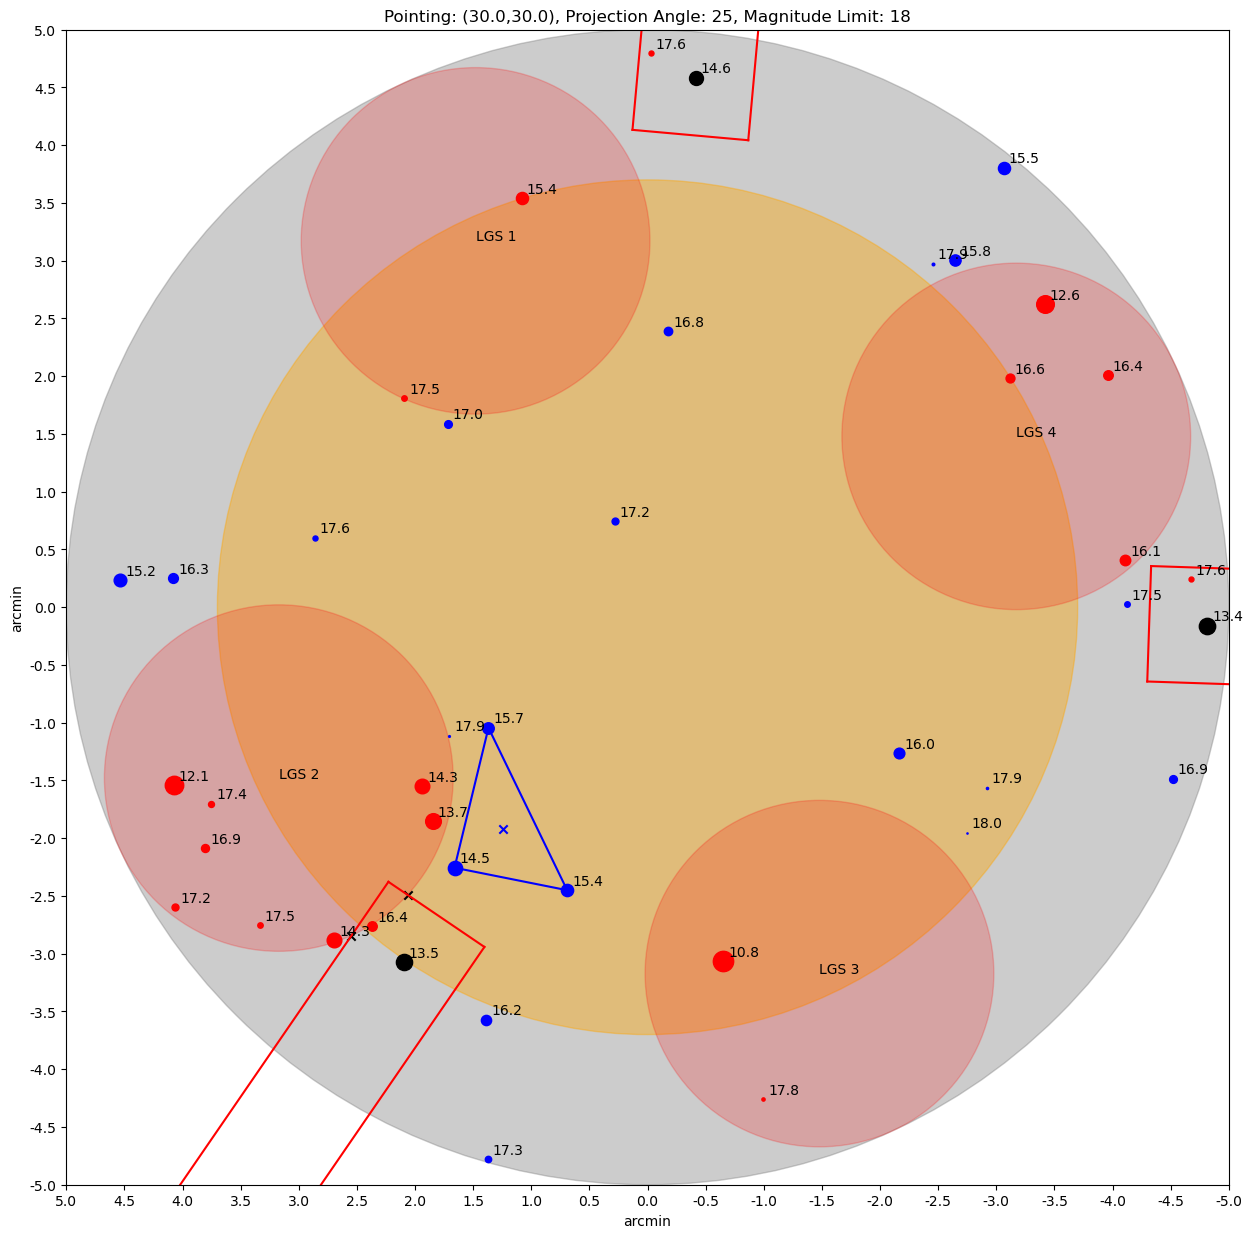

In [22]:
a.run(30.0,30.0, report=True,view=True, LGS_angle=25)

In [ ]:
a=FOV_stars(mag_limit=18)
a.GAIA_query(54.1,-27.8)


INFO: Query finished. [astroquery.utils.tap.core]


Conv stars:
0.0007219314575195312
Find stars:
0.00017595291137695312
LGS footprint stars:
0.00011801719665527344
PFS arm stars:
0.00013303756713867188
NGS stars:
1.5020370483398438e-05
One inside
Two inside
Stars in FOV = 24
Stars obscured by LGS footprints = 8
LGS footprint obscured stars lie in = [3, 3, 2, 3, 1, 4, 1, 4]
PFS stars available = 3
Stars vignetted by PFS arms = 0
NGS stars available = 9
NGS asterism area = 3.0 arcmin^2
NGS barycentre distance from centre = 1.1 arcmin 

Time taken = 0.0013s


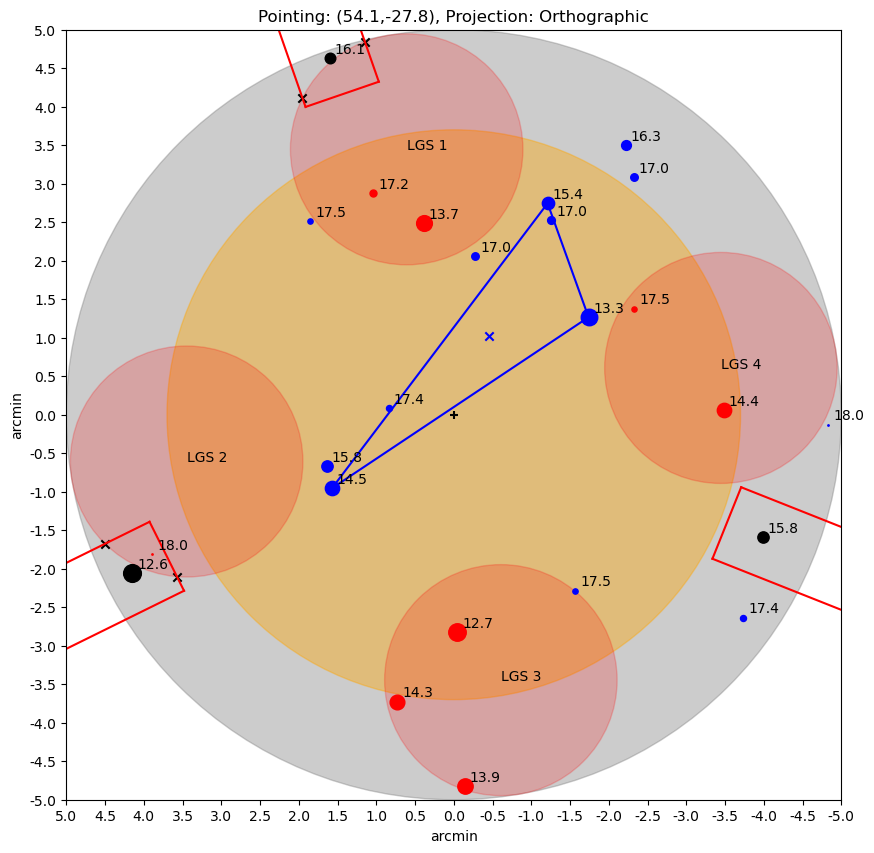

In [ ]:
a.run(54.1,-27.8, report=True,view=True, LGS_angle=10)

[3, 2]
[5, 3]


TypeError: append() takes exactly one argument (2 given)